# Project 2: Space Rats
## The Ship & Initializations

In [2728]:
import random

#Initializing the Ship as Per The Instructions Laid out
def get_cells_with_1_open_neighbor(status, ship):
    res = []
    for i in range(1,len(ship)-1):
        for j in range(1,len(ship[i])-1):
            if ship[i][j] != status:
                continue
            count_open_neighbors = 0

            if i-1>=0:
                if ship[i-1][j] == "open":
                    count_open_neighbors+=1
            if i+1<len(ship):
                if ship[i+1][j] == "open":
                    count_open_neighbors+=1
            if j-1>=0:
                if ship[i][j-1] == "open":
                    count_open_neighbors+=1
            if j+1<len(ship[i]):
                if ship[i][j+1] == "open":
                    count_open_neighbors+=1

            if count_open_neighbors == 1:
                res.append((i,j))
    return res

def create_ship():
    r_x, r_y = 30, 30
    ship = [["blocked" for n in range(r_x)] for m in range(r_y)]

    row = random.randint(1, r_x-2)
    col = random.randint(1, r_y-2)
    ship[row][col] = "open"

    while True:
        cells_to_open = get_cells_with_1_open_neighbor("blocked", ship)
        if cells_to_open:
            i,j = cells_to_open[random.randint(0, len(cells_to_open)-1)]
            ship[i][j] = "open"
        else:
            break   

    deadends = get_cells_with_1_open_neighbor("open", ship)
    chosen_deadends = random.sample(deadends, len(deadends)//2)
    for i, j in chosen_deadends:
        neighbors = []
        if i-1>=0:
            if ship[i-1][j] == "blocked":
                neighbors.append((i-1,j))
        if j-1>=0:
            if ship[i][j-1] == "blocked":
                neighbors.append((i,j-1))  
        if i+1<len(ship):
            if ship[i+1][j] == "blocked":
                neighbors.append((i+1,j))
        if j+1<len(ship[i]):
            if ship[i][j+1] == "blocked":
                neighbors.append((i,j+1))
        if not neighbors:
            continue
        index = random.randint(0, len(neighbors)-1)
        row, col = neighbors[index]
        ship[row][col] = "open"

    for i in range(r_x):
        ship[i][0] = "blocked"
        ship[i][r_x-1] = "blocked"
        ship[0][i] = "blocked"
        ship[r_x-1][i] = "blocked"
    
    return ship

In [2729]:
from collections import deque

def start_settings():
    ship = create_ship()
    row = random.randint(1, 28)
    col = random.randint(1, 28)

    while ship[row][col] == "blocked":
        row = random.randint(1, 28)
        col = random.randint(1, 28)

    bot_pos = (row, col)
    possible_bot_pos = {(x, y) for x in range(1, 29) for y in range(1, 29) if ship[x][y] == "open"}

    row = random.randint(1, 28)
    col = random.randint(1, 28)
    while ship[row][col] == "blocked":
        row = random.randint(1, 28)
        col = random.randint(1, 28)

    rat_pos = (row, col)
    possible_rat_pos = {}
    count = 0
    for i in range(30):
        for j in range(30):
            if ship[i][j] == "open":
                possible_rat_pos[(i,j)] = 1
                count+=1

    possible_rat_pos = {key: value / count for key, value in possible_rat_pos.items()}

    return[ship, bot_pos, possible_bot_pos, rat_pos, possible_rat_pos]

## Phase 1: Identify Where the Bot Is

In [2730]:
#This function returns the number of blocked cells
def get_num_blocked_neighbors(ship,x,y):
    count = 0

    #Checks all 8 directions and if it is blocked increases the count
    if ship[x - 1][y] == "blocked": 
        count += 1
    if ship[x + 1][y] == "blocked": 
        count += 1
    if ship[x][y - 1] == "blocked": 
        count += 1
    if ship[x][y + 1] == "blocked": 
        count += 1
    if ship[x - 1][y - 1] == "blocked": 
        count += 1
    if ship[x - 1][y + 1] == "blocked": 
        count += 1
    if ship[x + 1][y - 1] == "blocked": 
        count += 1
    if ship[x + 1][y + 1] == "blocked": 
        count += 1

    return count

#Function to update the possible positions of the bot depending on how many blocked neighbors it has
def update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos):

    #Create a new set to return once the calculations are finished
    new_possible_bot_pos = set()

    #Loop through all of the possible positions the bot could be in
    for (x,y) in possible_bot_pos:
        #Check how many blocked neighbors this cell has
        curr_pos_blocked_neighbors = get_num_blocked_neighbors(ship, x,y)

        #If it has the same number of blocked cells as desired we add it to our new set
        if curr_pos_blocked_neighbors == num_blocked_neighbors:
            new_possible_bot_pos.add((x,y))
        
    return new_possible_bot_pos

#Function to update the possible positions of the bot depending on the direction we move in
def update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos):
    
    #Create a new set to return once the calculations are finished
    new_possible_bot_pos = set()

    #Loop through all of the possible positions the bot could be in and if it is possible to move in the desired direction from that cell we add it to the set otherwise we do not
    for (x, y) in possible_bot_pos:

        #The following if statements go through what the desired direction is and check if it is possible to move in that direction from each possible location of the bot
        if direction == "up":
            if move_success and ship[x - 1][y] == "open":
                new_possible_bot_pos.add((x - 1, y))
            elif not move_success and ship[x - 1][y] == "blocked":
                new_possible_bot_pos.add((x, y))
        elif direction == "down":
            if move_success and ship[x + 1][y] == "open":
                new_possible_bot_pos.add((x + 1, y))
            elif not move_success and ship[x + 1][y] == "blocked":
                new_possible_bot_pos.add((x, y))
        elif direction == "left":
            if move_success and ship[x][y - 1] == "open":
                new_possible_bot_pos.add((x, y - 1))
            elif not move_success and ship[x][y - 1] == "blocked":
                new_possible_bot_pos.add((x, y))
        elif direction == "right":
            if move_success and ship[x][y + 1] == "open":
                new_possible_bot_pos.add((x, y + 1))
            elif not move_success and ship[x][y + 1] == "blocked":
                new_possible_bot_pos.add((x, y))

    return new_possible_bot_pos

#Code for phase 1 of the baseline bot
def phase_1(ship, bot_pos, possible_bot_pos):

    #Initialize the neccessary conditions
    x,y = bot_pos
    time = 0
    #Wiggle array contains recent positions and ensures we do not go back and forth over the same positions
    wiggle = []
    num_sense_blocked_neighbors = 0
    num_attempted_moves = 0

    while True:
        #If there is only 1 cell that is possible to be the bot location return it 
        if len(possible_bot_pos) == 1:
            return [possible_bot_pos.pop(), num_sense_blocked_neighbors, num_attempted_moves]
            
        #Utilize time%2 to alternate at every time step
        if time % 2 == 0:

            #Check the number of blocked neighbors at the current location and update the possible bot locations depending on that
            num_blocked_neighbors = get_num_blocked_neighbors(ship, x,y)
            possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos)
            num_sense_blocked_neighbors+=1
        else:
            num_attempted_moves+=1

            #Conditions to check if a wiggle has occured, if it has move in a random direction
            if len(wiggle) > 3 and (wiggle[0] == wiggle[2] and wiggle[1] == wiggle[3]):
                directions = ["up", "down", "left", "right"]
                direction = random.choice(directions)
            #If there is no wiggle calculate the most probable direction and choose that as the direction to move
            else: 
                direction_counts = {
                        "up": 0,
                        "down": 0,
                        "left": 0,
                        "right": 0
                }
        
                for (x, y) in possible_bot_pos:
                    if ship[x - 1][y] == "open":
                        direction_counts["up"] += 1
                    if ship[x + 1][y] == "open":
                        direction_counts["down"] += 1
                    if ship[x][y - 1] == "open":
                        direction_counts["left"] += 1
                    if ship[x][y + 1] == "open":
                        direction_counts["right"] += 1

                max_count = max(direction_counts.values())
                best_directions = [dir for dir, count in direction_counts.items() if count == max_count]
                direction = random.choice(best_directions)
            

            #Conditions to check if the move in the intended direction is successfull, if it is we set move success to true other wise we set it to false
            move_success = True
            if direction == "up": 
                if ship[x-1][y] == "open":
                    x-=1
                    move_success = True
                else:
                    move_success = False
            elif direction == "down": 
                if ship[x+1][y] == "open":
                    x+=1
                    move_success = True
                else:
                    move_success = False
            elif direction == "left":
                if ship[x][y-1] == "open":
                    y-=1
                    move_success = True
                else:
                    move_success = False
            if direction == "right": 
                if ship[x][y+1] == "open":
                    y+=1
                    move_success = True
                else:
                    move_success = False
            
        
            #If the move is successfull we append it to wiggle, wiggle only looks at the last 4 decisions
            if move_success:
                wiggle.append(direction)
                if len(wiggle) > 4:
                    wiggle = wiggle[1:]

            #Update the possible positions of the bot depending on the intended directio 
            possible_bot_pos = update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos)
        
        time+=1

## Phase 2: Track the Space Rat

In [2731]:
import math
from collections import deque
import copy
import matplotlib.pyplot as plt

#This function utilizes BFS to return an array of directions which is the shortest path between two cells
def shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry):
    q = deque()
    q.append((bx,by))

    #keep track of the preceding cell to the current cell
    precede = {(bx,by) : None}
    visit = set()
    visit.add((bx,by))

    while q:
        i, j = q.popleft()
        index = (i, j)

        #if the current cell is the possible rat cell create a list of directions from the start
        if i == prx and j == pry:
            directions = []

            #utilize the precede dictionary to reverse the list of directions
            while index is not None:
                directions.append(index)
                index = precede[index]

            #return a reversed list of directions by utilizing precede I calculate the path from the bot to the possible rat cell
            directions = directions[::-1]
            return directions[1:]

        #next 4 if statements check the neighbors and if they are valid are added to the queue
        if i-1>=0 and (i-1, j) not in visit:
            if ship[i-1][j] != "blocked":
                q.append((i-1,j))
                visit.add((i-1,j))
                precede[(i-1,j)] = index

        if j-1>=0 and (i, j-1) not in visit:
            if ship[i][j-1] != "blocked":
                q.append((i,j-1))
                visit.add((i,j-1))
                precede[(i,j-1)] = index

        if i+1<len(ship) and (i+1, j) not in visit:
            if ship[i+1][j] != "blocked":
                q.append((i+1,j))
                visit.add((i+1,j))
                precede[(i+1,j)] = index

        if j+1<len(ship[i]) and (i, j+1) not in visit:
            if ship[i][j+1] != "blocked":
                q.append((i,j+1))
                visit.add((i,j+1))
                precede[(i,j+1)] = index

    #if there is no path return an empty list
    return []

#This function returns the probability of getting a ping depending on the distance between the bot and the rat utilizing the formula given
def get_ping(bx, by, rx, ry, a):
    d = abs(bx-rx) + abs(by-ry)
    prob_ping = math.exp(-1*a*(d-1))
    return prob_ping

#This function updates our knowledge base based on if we here a ping or we dont here a ping
def update_possible_rat_pos(bx, by, ping, a, possible_rat_pos):
    #Formula: p(rat at i,j | ping) = p(ping | rat at i,j) * p(rat at ij ) / p(ping)
    #Formula: p(rat at i,j | not_ping) = p(not_ping | rat at i,j) * p(rat at ij ) / p(not_ping overall)

    #New knowledge base that we return
    new_possible_rat_pos = new_possible_rat_pos = copy.deepcopy(possible_rat_pos)

    #Use the law of total probability to calculate the overall probability of hearing a ping
    prob_ping = 0
    for index, prob_rat_at_xy in possible_rat_pos.items():
        x,y = index
        prob_ping += get_ping(bx, by, x, y, a)*prob_rat_at_xy
    
    #Use the law of total probability to calculate the overall probability of not hearing a ping
    prob_not_ping = 0
    for index, prob_rat_at_xy in possible_rat_pos.items():
        x,y = index
        prob_not_ping_given_rat_xy = 1 - get_ping(bx, by, x, y, a)
        prob_not_ping += prob_not_ping_given_rat_xy*prob_rat_at_xy
    
    #The following code adjusts the probabilites in the knowledge base utilizing the formula we have depending on ping or not ping
    if ping:
        for index, prob_rat_at_xy in possible_rat_pos.items():
            x,y = index

            if x==bx and y==by:
                new_possible_rat_pos[index] = 0
                continue

            #calculate p(ping | rat at i,j)
            prob_ping_given_rat_at_xy = get_ping(bx, by, x, y, a)

            #calculate overall prob of getting a ping
            #p(rat in each open cell) * p(ping of the bot to that cell)
            new_possible_rat_pos[index] = (prob_ping_given_rat_at_xy * prob_rat_at_xy) / prob_ping
    else:
        for index, prob_rat_at_xy in possible_rat_pos.items():
            x,y = index
            
            if x==bx and y==by:
                new_possible_rat_pos[index] = 0
                continue
            #calculate p(ping | rat at i,j)
            prob_not_ping_given_rat_at_xy = 1 - get_ping(bx, by, x, y, a)
            new_possible_rat_pos[index] = (prob_not_ping_given_rat_at_xy * prob_rat_at_xy) / prob_not_ping
    
    #Normalize the probabilites
    total_prob = sum(new_possible_rat_pos.values())
    return {key: value / total_prob for key, value in new_possible_rat_pos.items()}

#Code for phase 2 of the baseline bot
def phase_2(ship, bot_pos, rat_pos, possible_rat_pos, a):
    #Initialize important values
    bx, by = bot_pos
    rx, ry = rat_pos
    time = 0
    num_ping = 0
    num_moves = 0
    while True:   
        
        #Utilize time % 2 to alternate between the time steps
        if time % 2 == 0:
            num_ping+=1

            #If we are at the bot return
            if bx==rx and by== ry:
                return [(bx, by), num_ping, num_moves, num_ping + num_moves]
            
            #calculate the probability of a ping happening and use random.random() to see if a ping does happen
            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            #update the knowledge base depending on if we get a ping or not
            possible_rat_pos = update_possible_rat_pos(bx, by, ping, a, possible_rat_pos)
        else:
            num_moves+=1

            #Find the cell with the highest probability of having a rat, get the shortest path to that cell, move one step to that cell
            prx, pry = max(possible_rat_pos, key=possible_rat_pos.get)
            
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            bx, by = directions[0]
           
        time+=1

### How space rat knowledge base is updated -- Data & Analysis Question 1:
#### For every cell (i,j) where (i,j) is a valid possible position of the space rat we need to re-calculate the p{rat @ (i,j), | ping == True} or p{rat @ (i,j), | ping == False} depending on if you hear a ping or not. First lets take the case of hearing ping is true. The following is the math I used to update the knowledge base. I use Bayes Formula [P(A∣B)= [P{B∣A}*P{A}/ P{B}] and the formula for total probability [P(A)=∑n [P{A∣Bn}*P{Bn}]] to create this calculation. 
#### P{rat @ (i,j) | ping==True} = [p{ping==True | rat @ (i,j)} * prob{rat @ (i,j)}] / p{ping == True} | p{ping==True | rat @ (i,j)} = e^(-a*d(bot_pos, (i,j))-1) as already pre-defined | Using the formula for total probability: p(ping==True) = ∑n[P{ping==True∣ Rat @ (i,j)}*P{Rat @ (i,j)}] | if you do not hear a ping do the same math but with P{rat @ (i,j) | not_ping==True}.

## My Own Bot: Phase 1 (Find the Bot)

In [2732]:
from collections import defaultdict

#Function to calculate the utility of sensing blocked neighbors based on possible bot positions
def get_utility_sense_neighbors(ship, possible_bot_pos):
    
    # Helper function to count the number of blocked neighbors for each possible bot position
    def get_blocked_cells():
        blocked_cells = defaultdict(int)
        for (x, y) in possible_bot_pos:
            count = get_num_blocked_neighbors(ship, x, y) 
            blocked_cells[count] += 1 
        return blocked_cells

    total_cells = len(possible_bot_pos) 
    blocked_cells = get_blocked_cells() 

    expected_num_cells_reduced = 0

    #Calculate expected number of cells reduced by sensing for blocked neighbors
    for count, cell_count in blocked_cells.items():
        num_cells_reduced = total_cells - cell_count
        expected_num_cells_reduced += num_cells_reduced * (cell_count / total_cells)
    
    return expected_num_cells_reduced

# Function to calculate the utility of moving in each possible direction
def get_utility_move(ship, possible_bot_pos):
    
    #function to calculate the probability of moving in each direction
    def get_direction_probs():
        direction_probs = defaultdict(int)
        for (x, y) in possible_bot_pos:
            # Check each direction for every possible cell to see if it's open and increment respective direction count
            if ship[x-1][y] == "open":
                direction_probs["up"] += 1
            if ship[x+1][y] == "open":
                direction_probs["down"] += 1
            if ship[x][y-1] == "open":
                direction_probs["left"] += 1
            if ship[x][y+1] == "open":
                direction_probs["right"] += 1
        return direction_probs

    total_cells = len(possible_bot_pos)  
    direction_probs = get_direction_probs() 

    expected_num_cells_reduced = 0

    # Calculate expected number of cells reduced by moving in each direction
    for direction, cell_count in direction_probs.items():
        num_cells_reduced = total_cells - cell_count
        expected_num_cells_reduced += num_cells_reduced * (cell_count / total_cells)
    
    return expected_num_cells_reduced

# Phase 1 for my bot
def my_phase_1(ship, bot_pos, possible_bot_pos):
    x, y = bot_pos  # Initial bot position
    wiggle = []  # List to track movement patterns
    last_move_sense_neighbors = False  # Flag to track last move type
    num_sense_blocked_neighbors = 0  # Count of sense operations
    num_attempted_moves = 0  # Count of attempted moves

    # Loop until only one possible bot position is left
    while True:
        if len(possible_bot_pos) == 1:
            return [possible_bot_pos.pop(), num_sense_blocked_neighbors, num_attempted_moves]
        
        # Calculate utilities for sensing neighbors and moving
        utility_sense_neighbors = get_utility_sense_neighbors(ship, possible_bot_pos)
        utility_move = get_utility_move(ship, possible_bot_pos)

        # Choose the action depending on which utility is higher - which action causes the greatest reduction in number of possible bot positions
        if utility_sense_neighbors >= utility_move and not last_move_sense_neighbors:
            #Sensing two times in a row from the same position does not provide much benefit

            #Code below senses for blocked neighbors then adjusts the possible bot positions
            num_sense_blocked_neighbors += 1  
            num_blocked_neighbors = get_num_blocked_neighbors(ship, x, y)  
            possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos)
            last_move_sense_neighbors = True
        else:

            last_move_sense_neighbors = False
            num_attempted_moves += 1

            # Check for a wiggle and if it exists randomly choose a direction
            if len(wiggle) > 3 and (wiggle[0] == wiggle[2] and wiggle[1] == wiggle[3]):
                directions = ["up", "down", "left", "right"]
                direction = random.choice(directions)
            else:
                # Calculate probabilities for each direction based on open paths
                direction_counts = {
                    "up": 0,
                    "down": 0,
                    "left": 0,
                    "right": 0
                }
                for (x, y) in possible_bot_pos:
                    if ship[x - 1][y] == "open":
                        direction_counts["up"] += 1
                    if ship[x + 1][y] == "open":
                        direction_counts["down"] += 1
                    if ship[x][y - 1] == "open":
                        direction_counts["left"] += 1
                    if ship[x][y + 1] == "open":
                        direction_counts["right"] += 1

                # Calculate direction probabilities based on counts
                direction_prob = {key: value / len(possible_bot_pos) for key, value in direction_counts.items()}
                directions = list(direction_prob.keys())
                probabilities = list(direction_prob.values())
                direction = random.choices(directions, probabilities, k=1)[0]

            # Attempt to move in the selected direction and update position
            move_success = False
            if direction == "up" and ship[x-1][y] == "open":
                x -= 1
                move_success = True
            if direction == "down" and ship[x+1][y] == "open":
                x += 1
                move_success = True
            if direction == "left" and ship[x][y-1] == "open":
                y -= 1
                move_success = True
            if direction == "right" and ship[x][y+1] == "open":
                y += 1
                move_success = True

            #Update the wiggle list to keep track of our movements
            if move_success:
                wiggle.append(direction)
                if len(wiggle) > 4:
                    wiggle = wiggle[1:]

            # Update possible bot positions based on the move and if it was successful
            possible_bot_pos = update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos)


### Analysis of my bot (phase 1) - Data & Analysis Question 2: 
#### The code above is my bot's improvement upon phase_1 from the baseline bot. An overview to explain how my bot improves on baseline bot phase 1 is that before we make a decision (whether to count the number of blocked cells vs moving) we first calculate the utility of each decision. The utility functions help us decide whether to sense or move. To calculate the utility of sensing the number of blocked cells, I calculate the expected number of cells that are reduced. The reason for this is because the utility of sensing is set as the expected number of reduced cells from sensing. To calculate this value we have a dictionary of all the possible number of blocked cells. We then iterate and for each potential number of blocked cells we update the expected value of the number of cells removed from possible positions as expected_num_cells_reduced += num_cells_reduced*(cell_count/total_cells). Because we don't know for sure how many cells are actually blocked we sum over all the possible blocked counts and add the number of cells that will be reduce times the probability of that block count occuring. By calculating the expected value of the number of cells reduced we can get the utility of moving. The second step is to calculate the utility of moving. Just as with sensing blocked neighbors utility of moving = expected value of the number of cells removed from the possible positions. However, this time we count the probability of each move (up, down, left, right), calculate the number of cells reduced per move, then multiply this number by the probability of that move occuring. By doing so we capture the expected value of the number of cells reduced by moving. Since both of these utilites involve E[num cells reduced] comparing the choice sensing neighbors or moving is simple. Instead of using alternating time steps to switch between each choice, we pick the appropriate move based on whoever has the highest utility. In laymens terms we choose the move that maximizes the expected number of cells that the bot is not located in.

## My Own Bot: Phase 2 (Track the Space Rat)

In [2733]:
# Function to select the position with the highest probability of having the rat and closest to the current bot position
def select_best_position(ship, bx, by, possible_rat_pos):
    max_prob = max(possible_rat_pos.values())
    max_prob_cells = [pos for pos, prob in possible_rat_pos.items() if prob == max_prob]

    prx, pry = min(max_prob_cells, key=lambda pos: len(shortest_path_to_possible_rat_pos(ship, bx, by, pos[0], pos[1])))

    return prx, pry

# My Bot's Phase 2
def my_bot_phase_2(ship, bot_pos, rat_pos, possible_rat_pos, a):

    #Initialze variables
    bx, by = bot_pos 
    rx, ry = rat_pos 
    time = 0
    num_ping = 0 
    num_moves = 0 
    mandatory_ping = False  # Check for mandatory pinging 
    visit = set()  # Set to track visited positions when moving without pinging
    visit.add((bx, by)) 
    commit = False  # Check to commit to a a high probability cell
    commit_next_move = False  # Check to commit on the next move

    while True:

        # Ping factor based on the value of `a`
        # ping_factor = (0.60653040999**(num_ping/25)) / (math.e ** (1 + math.log(1 + (math.e ** (10 * (a - 1.98 * (1 - max(possible_rat_pos.values())))) + 1e-10))))
        if 0 < a <= 0.1:
            ping_factor = 0.6
        if 0.1 < a <= 0.2:
            ping_factor = 0.55   

        #Factor to see how concentrated the values of the rat probability distribution are
        concentration = (ping_factor - max(possible_rat_pos.values()))
  
        #If concentration is negative (very high probability value) commit to that cell
        if (concentration < 0 and not mandatory_ping) or commit:
            # Select the best position to move to
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            num_moves += len(shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry))  
            bx, by = prx, pry

            #Set mandatory_ping to ensure the next action is a ping
            mandatory_ping = True
            visit.add((prx, pry))

            commit = False

        # If concentration is low ping or if mandatory ping is true
        elif random.random() < concentration or mandatory_ping:
            mandatory_ping = False  
            num_ping += 1 
            
            # Return if the rat is found
            if bx == rx and by == ry:
                return [(bx, by), num_ping, num_moves, num_ping + num_moves]
            
            # If the rat is not at the current cell set the probability to 0 and normalize
            possible_rat_pos[(bx, by)] = 0
            possible_rat_pos = {key: value / sum(possible_rat_pos.values()) for key, value in possible_rat_pos.items()}

            # Calculate the probability of hearing a ping and if ping happens
            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            #Clear the visited cells
            visit.clear()

            # Update knowledge base depending on the ping result
            possible_rat_pos = update_possible_rat_pos(bx, by, ping, a, possible_rat_pos)
            
            #Set commit to true if commit next move is true
            if commit_next_move:
                commit = True
                commit_next_move = False

        #Code to choose how to move
        else:
            #Select the best position to move to
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            
            # Find the shortest path to the target position
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            if directions:
                
                #If the current cell is cell we need to move to ping and commit
                if directions[0] in visit:
                    mandatory_ping = True
                    commit_next_move = True
                else:
                    
                    #Move one position towards the best position
                    bx, by = directions[0]
                    visit.add((bx, by))
                    num_moves += 1
            else:
                #If the current cell is selected as the best position ping then commit to readjust the knowledge base
                mandatory_ping = True
                commit_next_move = True
      
        time += 1


## Analysis of my bot (phase 2) - Data & Analysis Question 2:
### The way phase 2 of my bot works is by utilizing a ping factor formula and if a random variable is less than that we ping otherwise we move. The way I created this ping formula was through a process of trial and error to find the constants and a general understanding of how we need to either reward or not reward the action of pinging. This function was found over multiple trials to tweak and manipulate the ping factor when dealing with the information we have. We then calculate sense which is the difference between the ping factor and the max probability in the distribution. This value allows us to gauge whether we want to move or ping. The purpose of these ping_factor function is to account for how diffuse or concentrated the rat probability distribution is. If the highest probability in the distributon is very close or even greater than the ping factor that means the distribution is very localized and vice versa. This information allows us to know whether to ping or move. Then we find a random value and if it is less than sense we decide to ping. The reason for this is if the sensed value is very low this means that the distribution is probably very diffuse and spread out and listening for a ping would be. The random variable introduces a sense of randomness as this entire problem deals with random numbers. After we ping we then update the probabilites. If we decide to move we find the closest cell that has the maximum probability and move towards it. If at any point we see that the cell we are being instructed to move to or the current cell is the cell that is chosen, we force our algorithm to ping and then immediately commit to the cell with the highest probability. The reason for this is that if the bot is telling us to go back to a cell we already visited might result in oscillations so we commit. If the algorithm is telling us that the current cell we are on has the highest probability when we want to move might mean we have the same issues as we said above therefore we commit. Further improvement of this bot can occur when we optimize our ping_factor formula. A better ping_factor formula can result in significantly better results.

## Evaluate Performance

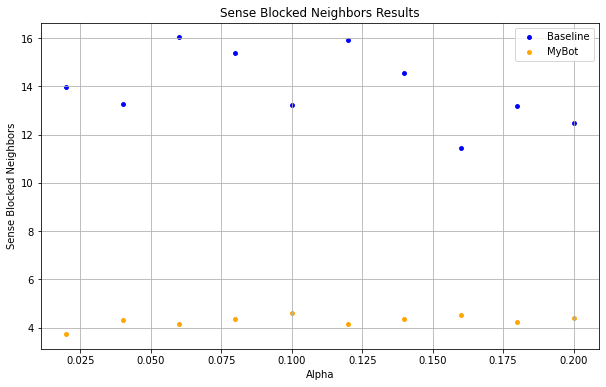

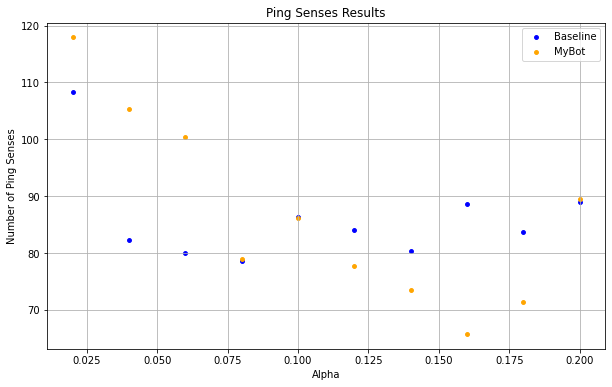

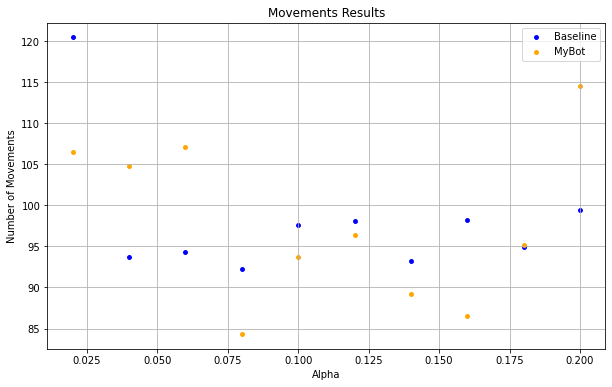

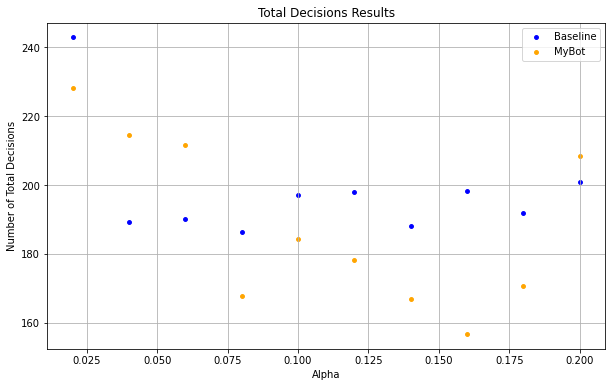

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def graph(baseline_num_sense_blocked_neighbors_results, mybot_num_sense_blocked_neighbors_results,
          baseline_num_ping_senses_results, mybot_num_ping_senses_results,
          baseline_num_movements_results, mybot_num_movements_results, baseline_total_results,my_bot_total_results):

    alpha_values = np.arange(0.01, 0.21, 0.02)

    # Graph 1: Sense Blocked Neighbors Results
    plt.figure(figsize=(10, 6))
    plt.scatter(alpha_values, list(baseline_num_sense_blocked_neighbors_results.values()), label="Baseline", color="blue", s=15)
    plt.scatter(alpha_values, list(mybot_num_sense_blocked_neighbors_results.values()), label="MyBot", color="orange", s=15)
    plt.xlabel("Alpha")
    plt.ylabel("Sense Blocked Neighbors")
    plt.title("Sense Blocked Neighbors Results")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graph 2: Ping Senses Results
    plt.figure(figsize=(10, 6))
    plt.scatter(alpha_values, list(baseline_num_ping_senses_results.values()), label="Baseline", color="blue", s=15)
    plt.scatter(alpha_values, list(mybot_num_ping_senses_results.values()), label="MyBot", color="orange", s=15)
    plt.xlabel("Alpha")
    plt.ylabel("Number of Ping Senses")
    plt.title("Ping Senses Results")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graph 3: Movements Results
    plt.figure(figsize=(10, 6))
    plt.scatter(alpha_values, list(baseline_num_movements_results.values()), label="Baseline", color="blue", s=15)
    plt.scatter(alpha_values, list(mybot_num_movements_results.values()), label="MyBot", color="orange", s=15)
    plt.xlabel("Alpha")
    plt.ylabel("Number of Movements")
    plt.title("Movements Results")
    plt.legend()
    plt.grid(True)
    plt.show()

    #Graph 4: Total Results
    plt.figure(figsize=(10, 6))
    plt.scatter(alpha_values, list(baseline_total_results.values()), label="Baseline", color="blue", s=15)
    plt.scatter(alpha_values, list(my_bot_total_results.values()), label="MyBot", color="orange", s=15)
    plt.xlabel("Alpha")
    plt.ylabel("Number of Total Decisions")
    plt.title("Total Decisions Results")
    plt.legend()
    plt.grid(True)
    plt.show()


def simulate():
    baseline_num_sense_blocked_neighbors_results = {}
    baseline_num_ping_senses_results = {}
    baseline_num_movements_results = {}

    mybot_num_sense_blocked_neighbors_results = {}
    mybot_num_ping_senses_results = {}
    mybot_num_movements_results = {}

    baseline_total_results = {}
    my_bot_total_results = {}

    for a in range(2, 21, 2):
        a = a / 100
        
        baseline_num_sense_blocked_neighbors = 0
        baseline_num_ping_senses = 0
        baseline_num_movements = 0

        mybot_num_sense_blocked_neighbors = 0
        mybot_num_ping_senses = 0
        mybot_num_movements = 0

        baseline_total = 0
        my_bot_total = 0

        num_simulations = 30
        for i in range(num_simulations):
            ship, bot_pos, possible_bot_pos, rat_pos, possible_rat_pos = start_settings()

            baseline_p1_results = phase_1(ship, bot_pos, possible_bot_pos)
            mybot_p1_results = my_phase_1(ship, bot_pos, possible_bot_pos)

            baseline_bot_pos = baseline_p1_results[0]
            mybot_bot_pos = mybot_p1_results[0]
            
            baseline_p2_results = phase_2(ship, baseline_bot_pos, rat_pos, possible_rat_pos, a)
            mybot_p2_results = my_bot_phase_2(ship, mybot_bot_pos, rat_pos, possible_rat_pos, a)

            baseline_num_sense_blocked_neighbors += baseline_p1_results[1]
            baseline_num_ping_senses += baseline_p2_results[1]
            baseline_num_movements += baseline_p1_results[2] + baseline_p2_results[2]
            baseline_total += baseline_num_sense_blocked_neighbors + baseline_num_ping_senses + baseline_num_movements

            mybot_num_sense_blocked_neighbors += mybot_p1_results[1]
            mybot_num_ping_senses += mybot_p2_results[1]
            mybot_num_movements += mybot_p1_results[2] + mybot_p2_results[2]
            my_bot_total += mybot_num_sense_blocked_neighbors + mybot_num_ping_senses + mybot_num_movements

        baseline_num_sense_blocked_neighbors_results[a] = baseline_num_sense_blocked_neighbors / num_simulations
        baseline_num_ping_senses_results[a] = baseline_num_ping_senses / num_simulations
        baseline_num_movements_results[a] = baseline_num_movements / num_simulations

        mybot_num_sense_blocked_neighbors_results[a] = mybot_num_sense_blocked_neighbors / num_simulations
        mybot_num_ping_senses_results[a] = mybot_num_ping_senses / num_simulations
        mybot_num_movements_results[a] = mybot_num_movements / num_simulations

        baseline_total_results[a] = baseline_num_sense_blocked_neighbors_results[a] + baseline_num_ping_senses_results[a] + baseline_num_movements_results[a]
        my_bot_total_results[a] = mybot_num_sense_blocked_neighbors_results[a] + mybot_num_ping_senses_results[a] + mybot_num_movements_results[a]

    graph(baseline_num_sense_blocked_neighbors_results, mybot_num_sense_blocked_neighbors_results, baseline_num_ping_senses_results, mybot_num_ping_senses_results, baseline_num_movements_results, mybot_num_movements_results, baseline_total_results, my_bot_total_results)


simulate()



## Analysis of Simulation
### Comparing the Number of Blocked Cells Sensing Actions: At all alpha values baseline bot will sense the number of blocked cells less. The reason for this is because baseline bot simply alternates between sensing blocked neighbors and moving. On the other hand my bot chooses a decision based on how it will reduce the number of possible bot positions. By choosing each decision based on its utility we minimize random and unneccessary moves resulting in lower sense blocked neighbor actions. When comparing pings we can see that my bot uses significantly more pings when compared with the baseline bot but performs less movements overall. The reason for this is because by pinging more my bot is able to localize where the rat is more efficiently. By pinging more we can reduce the number of movements neccessary. In fact baseline bots lack of pings in comparison to my bot can directly attribute to the reason as why it has a higher number of movements overall. In fact, there is clear correlation between my bot pinging more and reduced number of movements. Analyzing these graphs provides incite into the trade off between pinging and moving. My bot clearly prioritzes listening for a ping more than moving. In turn this results in a lower total movements and finding the rat more efficiently. Because of this my bot on average performs less decisions to reach the rat when compared to the baseline bot.

## Non Stationary Space Rat

### Previously, the space rat was assumed to be stationary. Now assume that in every timestep, after the bot takes an action, the space rat moves in a random open direction. - Work out the space rat knowledge base updates based on this. What changes, what probabilities do you need to calculate? Again, there is a correct answer.
#### The probability of the rat at a certain cell (i,j) is the probability that it was previously in one of the open neighbors of (i,j) and moved to (i,j). The math: P{rat @ (i,j) | ping} = Σ(1-> num_open_neighbors(i,j)) [ ((P{ping | rat @ (x,y)} * P{rat at (x,y)}) / P{ping}) * (1 / num_open_neighbors(x,y))]. Since the rat moves after the time step p(ping) wont change every time, therefore: P{rat @ (i,j) | ping} = Σ(1-> num_open_neighbors(i,j)) [ (P{ping | rat @ (x,y)} * P{rat at (x,y)}) * (1 / num_open_neighbors(x,y))] / P{ping}

### Simulation Comparing Both Bots With a Changing Rat Position (updated knowledge bases)

#### Bot 1 - I only change the knowledge base of this bot to test its original functionality

In [2735]:
#The following code is baseline bot 1 the rat moves at the end of every time step
def phase_1_rat_moves(ship, bot_pos, possible_bot_pos, rat_pos):
    x,y = bot_pos
    rx, ry = rat_pos
    time = 0
    wiggle = []
    num_sense_blocked_neighbors = 0
    num_attempted_moves = 0
    while True:
        if len(possible_bot_pos) == 1:
            return [possible_bot_pos.pop(), num_sense_blocked_neighbors, num_attempted_moves, (rx, ry)]
            
        if time % 2 == 0:
            num_blocked_neighbors = get_num_blocked_neighbors(ship, x,y)
            possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos)
            num_sense_blocked_neighbors+=1
        else:
            num_attempted_moves+=1
            if len(wiggle) > 3 and (wiggle[0] == wiggle[2] and wiggle[1] == wiggle[3]):
                directions = ["up", "down", "left", "right"]
                direction = random.choice(directions)
            else: 
                direction_counts = {
                        "up": 0,
                        "down": 0,
                        "left": 0,
                        "right": 0
                }
        
                for (x, y) in possible_bot_pos:
                    if ship[x - 1][y] == "open":
                        direction_counts["up"] += 1
                    if ship[x + 1][y] == "open":
                        direction_counts["down"] += 1
                    if ship[x][y - 1] == "open":
                        direction_counts["left"] += 1
                    if ship[x][y + 1] == "open":
                        direction_counts["right"] += 1

                max_count = max(direction_counts.values())
                best_directions = [dir for dir, count in direction_counts.items() if count == max_count]
                direction = random.choice(best_directions)
                    
            move_success = True
            if direction == "up": 
                if ship[x-1][y] == "open":
                    x-=1
                    move_success = True
                else:
                    move_success = False
            elif direction == "down": 
                if ship[x+1][y] == "open":
                    x+=1
                    move_success = True
                else:
                    move_success = False
            elif direction == "left":
                if ship[x][y-1] == "open":
                    y-=1
                    move_success = True
                else:
                    move_success = False
            if direction == "right": 
                if ship[x][y+1] == "open":
                    y+=1
                    move_success = True
                else:
                    move_success = False
            
        
            if move_success:
                wiggle.append(direction)
                if len(wiggle) > 4:
                    wiggle = wiggle[1:]

            possible_bot_pos = update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos)

        rat_directions = set()
        if ship[rx-1][ry] == "open":
            rat_directions.add((rx-1, ry))
        if ship[rx+1][ry] == "open":
            rat_directions.add((rx+1, ry))
        if ship[rx][ry-1] == "open":
            rat_directions.add((rx, ry-1))
        if ship[rx][ry+1] == "open":
            rat_directions.add((rx, ry+1))
        
        rx, ry = random.choice(list(rat_directions))
        
        time+=1



In [2736]:
#Function that updates the knowledge base taking into account that the rat moves
def update_possible_moving_rat_pos(ship, bx, by, ping, a, possible_rat_pos):
  
    #Formula: P{rat @ (i,j) | ping} = Σ(1-> num_open_neighbors(i,j)) [ (P{ping | rat @ (x,y)} * P{rat at (x,y)}) * (1 / num_open_neighbors(x,y))] / P{ping}

    new_possible_rat_pos = new_possible_rat_pos = copy.deepcopy(possible_rat_pos)

    #Calculate overall probability of ping
    prob_ping = 0
    for index, prob_rat_at_xy in possible_rat_pos.items():
        x,y = index
        prob_ping += get_ping(bx, by, x, y, a)*prob_rat_at_xy
    
    #Calculate overall probability of not ping
    prob_not_ping = 0
    for index, prob_rat_at_xy in possible_rat_pos.items():
        x,y = index
        prob_not_ping_given_rat_xy = 1 - get_ping(bx, by, x, y, a)
        prob_not_ping += prob_not_ping_given_rat_xy*prob_rat_at_xy
    
    #P{rat @ (i,j) | ping} = Σ(1-> num_open_neighbors(i,j)) [ (P{ping | rat @ (x,y)} * P{rat at (x,y)}) * (1 / num_open_neighbors(x,y))] / P{ping}
    if ping:
        for index, prob_rat_at_xy in possible_rat_pos.items():
            x,y = index

            #Add the neighbors of (x,y) to a set
            open_neighbors = set()
            if ship[x-1][y] == "open":
                open_neighbors.add((x-1, y))
            if ship[x+1][y] == "open":
                open_neighbors.add((x+1, y))
            if ship[x][y-1] == "open":
                open_neighbors.add((x, y-1))
            if ship[x][y+1] == "open":
                open_neighbors.add((x, y+1))

            #Code to perform the following part of the formula:  [(P{ping | rat @ (x,y)} * P{rat at (x,y)}) * (1 / num_open_neighbors(x,y))]
            temp_prob = 0
            for (z,u) in open_neighbors:
                prob_given_zu = get_ping(bx, by, z, u, a)
                prob_given_zu*= possible_rat_pos[(z,u)]
                prob_given_zu*=(1/len(open_neighbors))
                temp_prob+= prob_given_zu
            
            temp_prob = temp_prob / prob_ping
            new_possible_rat_pos[index] = temp_prob
    #P{rat @ (i,j) | not ping} = Σ(1-> num_open_neighbors(i,j)) [ (P{not ping | rat @ (x,y)} * P{rat at (x,y)}) * (1 / num_open_neighbors(x,y))] / P{not ping}
    else:
        for index, prob_rat_at_xy in possible_rat_pos.items():
            x,y = index
            
            #Add the neighbors of (x,y) to a set
            open_neighbors = set()
            if ship[x-1][y] == "open":
                open_neighbors.add((x-1, y))
            if ship[x+1][y] == "open":
                open_neighbors.add((x+1, y))
            if ship[x][y-1] == "open":
                open_neighbors.add((x, y-1))
            if ship[x][y+1] == "open":
                open_neighbors.add((x, y+1))

            #Code to perform the following part of the formula:  [(P{not ping | rat @ (x,y)} * P{rat at (x,y)}) * (1 / num_open_neighbors(x,y))]
            temp_prob = 0
            for (z,u) in open_neighbors:
                prob_given_zu = 1 - get_ping(bx, by, z, u, a)
                prob_given_zu*= possible_rat_pos[(z,u)]
                prob_given_zu*=(1/len(open_neighbors))
                temp_prob+= prob_given_zu
            
            temp_prob = temp_prob / prob_not_ping
            new_possible_rat_pos[index] = temp_prob

    
    #Normalize probabilites and return
    total_prob = sum(new_possible_rat_pos.values())
    return {key: value / total_prob for key, value in new_possible_rat_pos.items()}


#The following code is baseline bot 2 except the rat moves at the end of every time step and utilizes the new formula to update the knowledge base
def phase_2_rat_moves(ship, bot_pos, rat_pos, possible_rat_pos, a):
    bx, by = bot_pos
    rx, ry = rat_pos
    time = 0
    num_ping = 0
    num_moves = 0
    while True:   
        if time % 2 == 0:
            num_ping+=1
            if bx==rx and by== ry:
                return [(bx, by), num_ping, num_moves, time]
            
            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            possible_rat_pos = update_possible_moving_rat_pos(ship, bx, by, ping, a, possible_rat_pos)
        else:
            num_moves+=1
            prx, pry = max(possible_rat_pos, key=possible_rat_pos.get)
            
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            if directions:
                bx, by = directions[0]
        
        rat_directions = set()
            
        if ship[rx-1][ry] == "open":
            rat_directions.add((rx-1, ry))
        if ship[rx+1][ry] == "open":
            rat_directions.add((rx+1, ry))
        if ship[rx][ry-1] == "open":
            rat_directions.add((rx, ry-1))
        if ship[rx][ry+1] == "open":
            rat_directions.add((rx, ry+1))
        
        rx, ry = random.choice(list(rat_directions))
        time+=1

### My Bot - I only change the knowledge base to test its original functionality

In [2737]:
#The following code is the same as my bot phase 1 except the rat moves at the end of every time step
def my_phase_1_rat_moves(ship, bot_pos, possible_bot_pos, rat_pos):
    x,y = bot_pos
    rx, ry = rat_pos
    wiggle = []
    last_move_sense_neighbors = False
    num_sense_blocked_neighbors = 0
    num_attempted_moves = 0

    while True:
        if len(possible_bot_pos) == 1:
            return [possible_bot_pos.pop(), num_sense_blocked_neighbors, num_attempted_moves, (rx,ry)]
    
        utility_sense_neighbors = get_utility_sense_neighbors(ship, possible_bot_pos)
        utility_move = get_utility_move(ship, possible_bot_pos)

        if utility_sense_neighbors >= utility_move and not last_move_sense_neighbors:
            num_sense_blocked_neighbors+=1
            num_blocked_neighbors = get_num_blocked_neighbors(ship, x,y)
            possible_bot_pos = update_possible_bot_pos_by_neighbors(ship, num_blocked_neighbors, possible_bot_pos)
            last_move_sense_neighbors = True
        else:
            last_move_sense_neighbors = False
            num_attempted_moves +=1
            if len(wiggle) > 3 and (wiggle[0] == wiggle[2] and wiggle[1] == wiggle[3]):
                directions = ["up", "down", "left", "right"]
                direction = random.choice(directions)
            else: 
                direction_counts = {
                        "up": 0,
                        "down": 0,
                        "left": 0,
                        "right": 0
                }
        
                for (x, y) in possible_bot_pos:
                    if ship[x - 1][y] == "open":
                        direction_counts["up"] += 1
                    if ship[x + 1][y] == "open":
                        direction_counts["down"] += 1
                    if ship[x][y - 1] == "open":
                        direction_counts["left"] += 1
                    if ship[x][y + 1] == "open":
                        direction_counts["right"] += 1

                direction_prob = {key: value / len(possible_bot_pos) for key, value in direction_counts.items()}

                directions = list(direction_prob)
                probabilities = list(direction_prob.values())

                direction = random.choices(directions, probabilities, k=1)[0]
        
            move_success = False
            if direction == "up" and ship[x-1][y] == "open":
                x-=1
                move_success = True
            if direction == "down" and ship[x+1][y] == "open":
                x+=1
                move_success = True
            if direction == "left" and ship[x][y-1] == "open":
                y-=1
                move_success = True
            if direction == "right" and ship[x][y+1] == "open":
                y+=1
                move_success = True
        
            if move_success:
                wiggle.append(direction)
                if len(wiggle) > 4:
                    wiggle = wiggle[1:]

            possible_bot_pos = update_possible_bot_pos_by_move(ship, direction, move_success, possible_bot_pos)
        
        rat_directions = set()
            
        if ship[rx-1][ry] == "open":
            rat_directions.add((rx-1, ry))
        if ship[rx+1][ry] == "open":
            rat_directions.add((rx+1, ry))
        if ship[rx][ry-1] == "open":
            rat_directions.add((rx, ry-1))
        if ship[rx][ry+1] == "open":
            rat_directions.add((rx, ry+1))
        
        rx, ry = random.choice(list(rat_directions))

In [2738]:
#The following code is the same as my bot phase 2 except it includes the rat moving at the end of every time step and utilizes the updated formulas for updating the knowledge base
def my_bot_phase_2_rat_moves(ship, bot_pos, rat_pos, possible_rat_pos, a):
    bx, by = bot_pos
    rx, ry = rat_pos
    time = 0
    num_ping = 0
    num_moves = 0
    mandatory_ping = False
    # wiggle = []
    visit = set()
    visit.add((bx,by))
    commit = False
    commit_next_move = False
    while True:  

        
        # ping_factor = (0.60653040999**(num_ping/25)) / (math.e ** (1 + math.log(1 + (math.e ** (10 * (a - 1.98 * (1 - max(possible_rat_pos.values())))) + 1e-10))))

        if 0 < a <= 0.1:
            ping_factor = 0.6
        if 0.1 < a <= 0.2:
            ping_factor = 0.55   
        
        sense = (ping_factor- max(possible_rat_pos.values()))
  
        if (sense < 0 and not mandatory_ping) or commit:
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            num_moves += len(shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry))
            bx, by = prx, pry
            mandatory_ping = True
            visit.add((prx, prx))
            commit = False
        elif random.random() < sense or mandatory_ping:
            mandatory_ping = False
            num_ping+=1
            if bx==rx and by== ry:
                return [(bx, by), num_ping, num_moves, num_ping + num_moves]
            
            possible_rat_pos[(bx, by)] = 0
            possible_rat_pos = {key: value / sum(possible_rat_pos.values()) for key, value in possible_rat_pos.items()}

            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            visit.clear()
            possible_rat_pos = update_possible_moving_rat_pos(ship, bx, by, ping, a, possible_rat_pos)
            
            if commit_next_move:
                commit = True
                commit_next_move = False
        else:
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            if directions:
                if directions[0] in visit:
                    mandatory_ping = True
                    commit_next_move = True
                else:
                    bx, by = directions[0]
                    visit.add((bx,by))
                    num_moves+=1
            else:
                mandatory_ping = True
                commit_next_move= True

        rat_directions = set()
            
        if ship[rx-1][ry] == "open":
            rat_directions.add((rx-1, ry))
        if ship[rx+1][ry] == "open":
            rat_directions.add((rx+1, ry))
        if ship[rx][ry-1] == "open":
            rat_directions.add((rx, ry-1))
        if ship[rx][ry+1] == "open":
            rat_directions.add((rx, ry+1))
        
        rx, ry = random.choice(list(rat_directions))
      
        time+=1

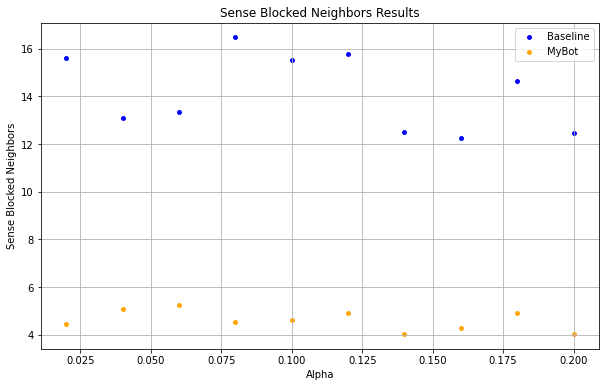

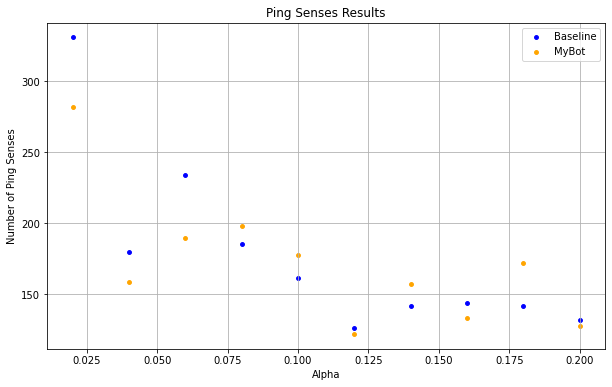

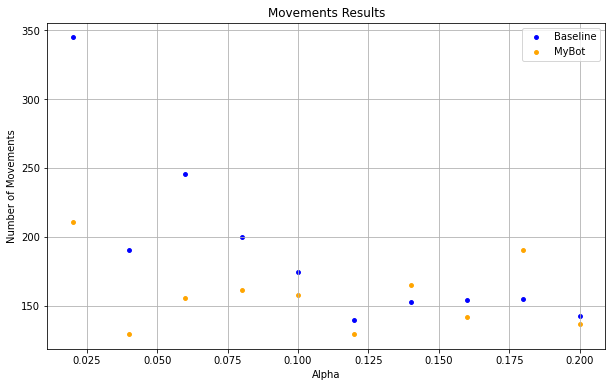

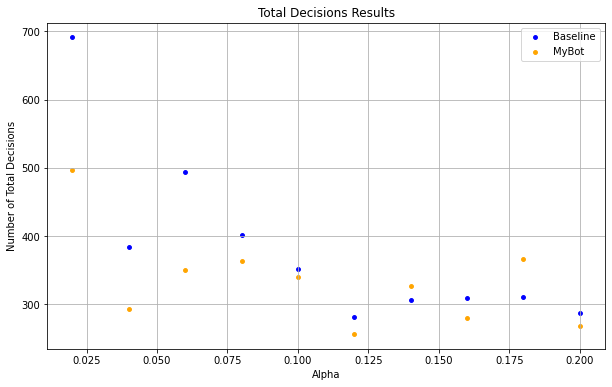

In [2739]:
def simulate_moving_rat():
    baseline_num_sense_blocked_neighbors_results = {}
    baseline_num_ping_senses_results = {}
    baseline_num_movements_results = {}

    mybot_num_sense_blocked_neighbors_results = {}
    mybot_num_ping_senses_results = {}
    mybot_num_movements_results = {}

    baseline_total_results = {}
    my_bot_total_results = {}

    for a in range(1, 21, 2):
        a = a / 100
        # print(f"Running simulations for Alpha value: {a}")
        
        # Reset counters for each value of `a`
        baseline_num_sense_blocked_neighbors = 0
        baseline_num_ping_senses = 0
        baseline_num_movements = 0

        mybot_num_sense_blocked_neighbors = 0
        mybot_num_ping_senses = 0
        mybot_num_movements = 0


        baseline_total = 0
        my_bot_total = 0

        num_simulations = 30
        for i in range(num_simulations):
            # print(f"\t{i}")
            ship, bot_pos, possible_bot_pos, rat_pos, possible_rat_pos = start_settings()

            baseline_p1_results = phase_1_rat_moves(ship, bot_pos, possible_bot_pos, rat_pos)
            rat_pos_p1 = baseline_p1_results[3]
            mybot_p1_results = my_phase_1_rat_moves(ship, bot_pos, possible_bot_pos, rat_pos)
            rat_pos_mybot_p1 = mybot_p1_results[3]

            baseline_bot_pos = baseline_p1_results[0]
            mybot_bot_pos = mybot_p1_results[0]
            
            baseline_p2_results = phase_2_rat_moves(ship, baseline_bot_pos, rat_pos_p1, possible_rat_pos, a)
            mybot_p2_results = my_bot_phase_2_rat_moves(ship, mybot_bot_pos, rat_pos_mybot_p1, possible_rat_pos, a)

            baseline_num_sense_blocked_neighbors += baseline_p1_results[1]
            baseline_num_ping_senses += baseline_p2_results[1]
            baseline_num_movements += baseline_p1_results[2] + baseline_p2_results[2]
            baseline_total += baseline_num_sense_blocked_neighbors + baseline_num_ping_senses + baseline_num_movements

            mybot_num_sense_blocked_neighbors += mybot_p1_results[1]
            mybot_num_ping_senses += mybot_p2_results[1]
            mybot_num_movements += mybot_p1_results[2] + mybot_p2_results[2]
            my_bot_total += mybot_num_sense_blocked_neighbors + mybot_num_ping_senses + mybot_num_movements

        baseline_num_sense_blocked_neighbors_results[a] = baseline_num_sense_blocked_neighbors / num_simulations
        baseline_num_ping_senses_results[a] = baseline_num_ping_senses / num_simulations
        baseline_num_movements_results[a] = baseline_num_movements / num_simulations

        mybot_num_sense_blocked_neighbors_results[a] = mybot_num_sense_blocked_neighbors / num_simulations
        mybot_num_ping_senses_results[a] = mybot_num_ping_senses / num_simulations
        mybot_num_movements_results[a] = mybot_num_movements / num_simulations
        
        baseline_total_results[a] = baseline_num_sense_blocked_neighbors_results[a] + baseline_num_ping_senses_results[a] + baseline_num_movements_results[a]
        my_bot_total_results[a] = mybot_num_sense_blocked_neighbors_results[a] + mybot_num_ping_senses_results[a] + mybot_num_movements_results[a]

    graph(baseline_num_sense_blocked_neighbors_results, mybot_num_sense_blocked_neighbors_results, baseline_num_ping_senses_results, mybot_num_ping_senses_results, baseline_num_movements_results, mybot_num_movements_results, baseline_total_results, my_bot_total_results)


simulate_moving_rat()


### How does the performance change? Comparison as alpha increase:
#### The performance of both bots shows that the total movements and pings significantly increase whereas the number of blocked neighbor sensing actions appears to be consistent from when the rat doesn't move. The reason for this is because phase 1 of both bots does not account for the rat moving. On the other hand a moving rat showcases the importance of pinging. My bot pings significantly more than the baseline bot. By prioritizing pinging my bot is able to localize to where the rat is with its new knowledge base update formula wheras the baseline bot cannot. As alpha increases we see a clear drop off on the number of pings my bot does and the number of movements it makes starts to get closer to baseline bot. The reason for this is because of the constants we use at higher alpha values are not effectivley factoring in the drop of higher alpha values cause. Overall for my bot we see that the number of pings we see drop off as alpha increases and number of movements goes up. 

### Improving the Bot Design

In [2740]:
def my_bot_phase_2_rat_moves_improvement(ship, bot_pos, rat_pos, possible_rat_pos, a):
    bx, by = bot_pos
    rx, ry = rat_pos
    time = 0
    num_ping = 0
    num_moves = 0
    mandatory_ping = False
    # wiggle = []
    visit = set()
    visit.add((bx,by))
    commit = False
    commit_next_move = False
    while True:  

        
        # ping_factor = (0.60653040999**(num_ping/25)) / (math.e ** (1 + math.log(1 + (math.e ** (10 * (a - 1.98 * (1 - max(possible_rat_pos.values())))) + 1e-10))))

        ping_factor = 0.575
        
        sense = (ping_factor- max(possible_rat_pos.values()))
  
        if (sense < 0 and not mandatory_ping) or commit:
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            num_moves += len(shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry))
            bx, by = prx, pry
            mandatory_ping = True
            visit.add((prx, prx))
            commit = False
        elif random.random() < sense or mandatory_ping:
            mandatory_ping = False
            num_ping+=1
            if bx==rx and by== ry:
                return [(bx, by), num_ping, num_moves, num_ping + num_moves]
            
            possible_rat_pos[(bx, by)] = 0
            possible_rat_pos = {key: value / sum(possible_rat_pos.values()) for key, value in possible_rat_pos.items()}

            prob_ping = get_ping(bx, by, rx, ry, a)
            ping = random.random() < prob_ping

            visit.clear()
            possible_rat_pos = update_possible_moving_rat_pos(ship, bx, by, ping, a, possible_rat_pos)
            
            if commit_next_move:
                commit = True
                commit_next_move = False
        else:
            prx, pry = select_best_position(ship, bx, by, possible_rat_pos)
            
            directions = shortest_path_to_possible_rat_pos(ship, bx, by, prx, pry) 

            if directions:
                if directions[0] in visit:
                    mandatory_ping = True
                    commit_next_move = True
                else:
                    bx, by = directions[0]
                    visit.add((bx,by))
                    num_moves+=1
            else:
                mandatory_ping = True
                commit_next_move= True

        rat_directions = set()
            
        if ship[rx-1][ry] == "open":
            rat_directions.add((rx-1, ry))
        if ship[rx+1][ry] == "open":
            rat_directions.add((rx+1, ry))
        if ship[rx][ry-1] == "open":
            rat_directions.add((rx, ry-1))
        if ship[rx][ry+1] == "open":
            rat_directions.add((rx, ry+1))
        
        rx, ry = random.choice(list(rat_directions))

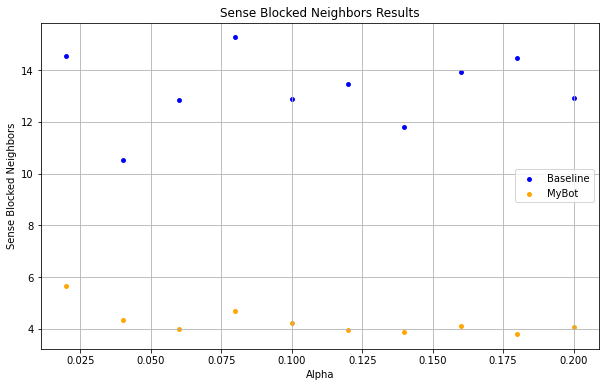

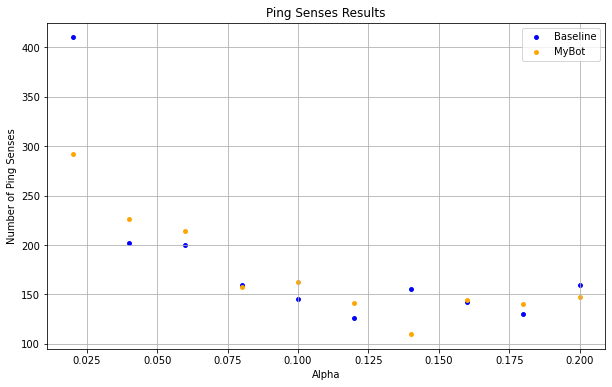

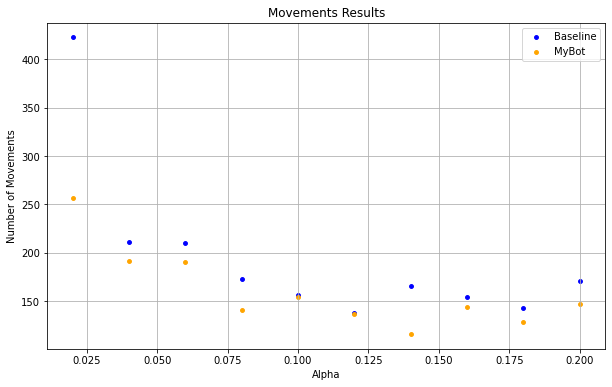

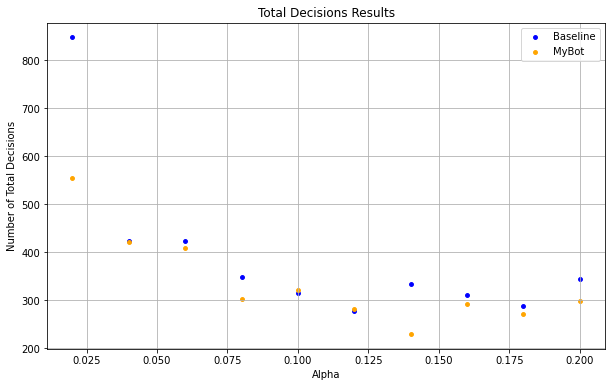

In [ ]:
def simulate_moving_rat_improvement():
    baseline_num_sense_blocked_neighbors_results = {}
    baseline_num_ping_senses_results = {}
    baseline_num_movements_results = {}

    mybot_num_sense_blocked_neighbors_results = {}
    mybot_num_ping_senses_results = {}
    mybot_num_movements_results = {}

    baseline_total_results = {}
    my_bot_total_results = {}

    for a in range(1, 21, 2):
        a = a / 100
        # print(f"Running simulations for Alpha value: {a}")
        
        # Reset counters for each value of `a`
        baseline_num_sense_blocked_neighbors = 0
        baseline_num_ping_senses = 0
        baseline_num_movements = 0

        mybot_num_sense_blocked_neighbors = 0
        mybot_num_ping_senses = 0
        mybot_num_movements = 0

        baseline_total = 0
        my_bot_total = 0

        num_simulations = 30
        for i in range(num_simulations):
            # print(f"\t{i}")
            ship, bot_pos, possible_bot_pos, rat_pos, possible_rat_pos = start_settings()

            baseline_p1_results = phase_1_rat_moves(ship, bot_pos, possible_bot_pos, rat_pos)
            rat_pos_p1 = baseline_p1_results[3]
            mybot_p1_results = my_phase_1_rat_moves(ship, bot_pos, possible_bot_pos, rat_pos)
            rat_pos_mybot_p1 = mybot_p1_results[3]

            baseline_bot_pos = baseline_p1_results[0]
            mybot_bot_pos = mybot_p1_results[0]
            
            baseline_p2_results = phase_2_rat_moves(ship, baseline_bot_pos, rat_pos_p1, possible_rat_pos, a)
            mybot_p2_results = my_bot_phase_2_rat_moves_improvement(ship, mybot_bot_pos, rat_pos_mybot_p1, possible_rat_pos, a)

            baseline_num_sense_blocked_neighbors += baseline_p1_results[1]
            baseline_num_ping_senses += baseline_p2_results[1]
            baseline_num_movements+= baseline_p1_results[2] + baseline_p2_results[2]
            baseline_total += baseline_num_sense_blocked_neighbors + baseline_num_ping_senses + baseline_num_movements

            mybot_num_sense_blocked_neighbors += mybot_p1_results[1]
            mybot_num_ping_senses += mybot_p2_results[1]
            mybot_num_movements += mybot_p1_results[2] + mybot_p2_results[2]
            my_bot_total += mybot_num_sense_blocked_neighbors + mybot_num_ping_senses + mybot_num_movements

        baseline_num_sense_blocked_neighbors_results[a] = baseline_num_sense_blocked_neighbors / num_simulations
        baseline_num_ping_senses_results[a] = baseline_num_ping_senses / num_simulations
        baseline_num_movements_results[a] = baseline_num_movements / num_simulations

        mybot_num_sense_blocked_neighbors_results[a] = mybot_num_sense_blocked_neighbors / num_simulations
        mybot_num_ping_senses_results[a] = mybot_num_ping_senses / num_simulations
        mybot_num_movements_results[a] = mybot_num_movements / num_simulations

        baseline_total_results[a] = baseline_num_sense_blocked_neighbors_results[a] + baseline_num_ping_senses_results[a] + baseline_num_movements_results[a]
        my_bot_total_results[a] = mybot_num_sense_blocked_neighbors_results[a] + mybot_num_ping_senses_results[a] + mybot_num_movements_results[a]

    graph(baseline_num_sense_blocked_neighbors_results, mybot_num_sense_blocked_neighbors_results, baseline_num_ping_senses_results, mybot_num_ping_senses_results, baseline_num_movements_results, mybot_num_movements_results, baseline_total_results, my_bot_total_results)


simulate_moving_rat_improvement()


### Changes Explained
#### Since the original phase 2 of my bot ended up performing much better than baseline bot to enhance it I changed the way I assigned ping factor. While the rat is stationary we have a different ping_factor for different ranges of alpha. When the rat is stationary, varying the ping factor with alpha makes sense because at different p values we have different chances of listening to the bot. With a moving rat this could cause issues for us as the rat keeps moving. From the trials I tested using a "average" of the previous ranges performed slightly better. Other than that I did not change much about the internal structure of how bot 2 runs. The reason for this is even when comparing it against baseline bot without the added adjustments, it performs better. My bot 2 performs so much better because of how I utilize pinging vs moving. With a moving rat, it could be beneficial at times to ping more often. Doing so can help the bot "track" the movement of the rat.  